# Smart Distribution Systems (B-KUL-H00P3A)
## Homework Project

Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
import time
import pickle
import datetime
from datafetcher import EliaTotalLoadForecastFetcher, EliaWindFetcher, EliaSolarFetcher, ElexysBelpexFetcher
import datetime as dt
from sklearn.cross_validation import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Setting start and end date

In [3]:
start_date = dt.datetime(2016,1,1)
end_date = dt.datetime(2018,4,23)

Fetch data

In [4]:
df_belpex = ElexysBelpexFetcher().fetch().price
df_solar = EliaSolarFetcher().fetch().LoadFactor[start_date:end_date]
df_wind = EliaWindFetcher().fetch().LoadFactor[start_date:end_date]
df_load = EliaTotalLoadForecastFetcher().fetch().value[start_date:end_date]

In [5]:
#df_wind.tail()
#df_load.tail()
#df_solar.tail()
#df_belpex.head()

In [6]:
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p = df_belpex[d]
    except KeyError:
        df_belpex.loc[d] = df_belpex[d-dt.timedelta(hours=1)]
df_belpex = df_belpex.sort_index()
df_belpex = df_belpex[start_date:end_date]

In [7]:
dates = pd.date_range(start=start_date, end=end_date, freq='15T')
for d in dates:
    try:
        p = df_wind[d]
    except KeyError:
        df_wind.loc[d] = df_wind[d-dt.timedelta(minutes=15)]

In [8]:
for d in dates:
    try:
        p = df_solar[d]
    except KeyError:
        df_solar.loc[d] = df_solar[d-dt.timedelta(minutes=15)]

In [9]:
for d in dates:
    try:
        p = df_load[d]
    except KeyError:
        df_load.loc[d] = df_load[d-dt.timedelta(minutes=15)]

In [10]:
df_belpex = df_belpex.fillna(method='pad')
df_solar =  df_solar.fillna(method='pad')
df_wind =  df_wind.fillna(method='pad')
df_load =  df_load.fillna(method='pad')

In [11]:
#dates = pd.date_range(start=start_date, end=end_date, freq='15T')
#for d in dates:
#    if(pd.isnull(df_wind[d])):
#        print('- missing wind data' + d) 
#    if(pd.isnull(df_solar[d])):
#        print('- missing solar data' + d) 
#    if(pd.isnull(df_load[d])):
#        print('- missing load data' + d) 

dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    if(pd.isnull(df_belpex[d])):
       print('- missing price data' + d) 

In [12]:
df_belpex = df_belpex.resample('15T').pad()

In [13]:
d = {'belpex': df_belpex.values,'load':df_load.values, 'solar': df_solar.values, 'wind': df_wind.values}
data = pd.DataFrame(index=df_belpex.index, data=d)
#data.head(10)
#data.tail(10)

In [14]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 5
data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std 
data['belpex'][(data.belpex <= mean - n_std*std)] = mean + n_std*std 

In [112]:
n_hours = 24
start = datetime.datetime(2017, 1, 2, 0, 0)
end = datetime.datetime(2018, 4, 21, 23, 45)
X = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)
X2 = data['load'][start:end].resample('1H').mean().reshape(-1, n_hours)
X3 = data['solar'][start:end].resample('1H').mean().reshape(-1, n_hours)
X4 = data['wind'][start:end].resample('1H').mean().reshape(-1, n_hours)


start = datetime.datetime(2017, 1, 3, 0, 0)
end = datetime.datetime(2018, 4, 22, 23, 45)
Y = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)


C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: reshape is deprecated and will raise in a subsequent releas

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
scaler.fit(X2)
scaler.fit(X3)
scaler.fit(X4)
scaler.fit(Y)

X = scaler.transform(X)
X2= scaler.transform(X2)
X3 = scaler.transform(X3)
X4 = scaler.transform(X3)
Y = scaler.transform(Y)

In [ ]:
Z = np.stack((X,X2,X3,X4),axis=1)

In [113]:
#print(X)
#print(Y)
#print(Z)
print('input_features ' + str(Z.shape))
print('target diminsions ' + str(Y.shape))

[[0.38640494 0.42046379 0.60671937 ... 0.37445731 0.54690246 0.5996513 ]
 [0.26390403 0.39961351 0.55231953 ... 0.38627593 0.31491652 0.42464858]
 [0.29752817 0.33472335 0.56116081 ... 0.46575012 0.37170475 0.47684428]
 ...
 [0.2807161  0.29281937 0.4610984  ... 0.34370478 0.29415641 0.36700447]
 [0.37722646 0.27115541 0.42323695 ... 0.44802219 0.18815905 0.27274709]
 [0.17320974 0.1623271  0.33045559 ... 0.19126869 0.14718805 0.15397189]]


In [115]:
import os

In [116]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD
from keras.layers.advanced_activations import LeakyReLU

In [119]:
neurons = [24,235,24]
activation_functions = ['relu','linear']

model = Sequential()
model.add (LSTM (  neurons[1] , activation = 'sigmoid', inner_activation = 'hard_sigmoid' , input_shape =(Z.shape[1],Z.shape[2]) ))
#model.add(Dense(neurons[0], input_shape=(Z.shape[1],Z.shape[2]), activation=activation_functions[0]))
#model.add(LeakyReLU(alpha=.001))
#model.add(Dense(neurons[1], activation=activation_functions[0]))
#model.add(LeakyReLU(alpha=.001))
#model.add(Flatten(input_shape=Z.shape[1:]))
model.add(Dense(neurons[2], activation=activation_functions[1]))
    
rprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)

C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(235, activation="sigmoid", input_shape=(4, 24), recurrent_activation="hard_sigmoid")`
  """


In [120]:
output_training = model.fit(Z, Y, epochs=800, batch_size=25, verbose=0)
mse = output_training.history['loss'][-1]
print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))

- mse is 76.7690 @ 800


In [122]:
Z_train_predict=model.predict(Z)
Z_train_predict=scaler.inverse_transform(Z_train_predict)
Y=scaler.inverse_transform(Y)

print(Z_train_predict[0])
print(Y)

trainScore = math.sqrt(mean_squared_error(Y[0], Z_train_predict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

[ 5475.9883  4476.0557  4067.4348  2941.394   3532.8296  4621.032
  6968.0938 10296.128  11923.238  11928.45   11380.828  10236.772
 11371.649   9059.318   8367.557   7643.096   9036.298  10215.093
 11597.507   9549.725   6791.2324  4609.879   5259.41    5295.616 ]
[[5784.8592 4403.23   4335.3122 ... 4072.638  6276.1192 5975.02  ]
 [4301.52   4201.674  3832.5    ... 4153.8996 4353.3544 4501.1938]
 [4708.668  3574.3924 3914.219  ... 4700.3424 4824.0312 4940.7721]
 ...
 [4505.094  3169.314  2989.3522 ... 3861.192  4181.2888 4015.7305]
 [5673.7188 2959.8924 2639.4026 ... 4578.45   3302.7528 3221.92  ]
 [3203.3208 1907.8684 1781.8338 ... 2813.0832 2963.1736 2221.627 ]]
Train Score: 1561.40 RMSE


In [123]:
#Test data

n_hours = 24
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 12, 30, 23, 45)
Test_X = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)
Test_X2 = data['load'][start:end].resample('1H').mean().reshape(-1, n_hours)
Test_X3 = data['solar'][start:end].resample('1H').mean().reshape(-1, n_hours)
Test_X4 = data['wind'][start:end].resample('1H').mean().reshape(-1, n_hours)

start = datetime.datetime(2016, 1, 2, 0, 0)
end = datetime.datetime(2016, 12, 31, 23, 45)
Test_Y = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)


C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Users\Udvardy\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use 

In [ ]:
scaler.fit(Test_X)
scaler.fit(Test_X2)
scaler.fit(Test_X3)
scaler.fit(Test_X4)

Test_X = scaler.transform(Test_X)
Test_X2= scaler.transform(Test_X2)
Test_X3 = scaler.transform(Test_X3)
Test_X4 = scaler.transform(Test_X4)

In [ ]:
Test_Z = np.stack((Test_X,Test_X2,Test_X3,Test_X4),axis=1)

In [124]:
def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)

predict_nn = model.predict(Test_Z)
predict_nn=scaler.inverse_transform(predict_nn)

print(get_accuracy(Test_Y.flatten(), predict_nn.flatten()))


0.3540333716756418


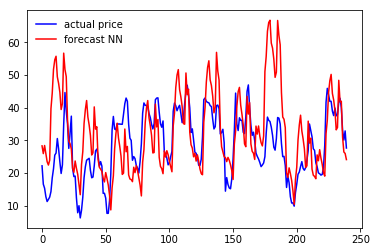

In [125]:
# Plots
plt.figure()
plt.plot(Test_Y[:10,:].flatten(), color='blue', label='actual price')
plt.plot(predict_nn[:10,:].flatten(), color='red', label='forecast NN')
plt.legend(frameon=False)
plt.show()